In [1]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = Path('../data/asd/raw')
freqs = np.linspace(4, 12, 41)

info = pd.read_csv(path / 'path_file.csv')
info['fn'] = info['fn'].str.replace('и' + chr(774), 'й') # For some reason, filenames encode й as 2 unicode characters
info = info.groupby("fn").filter(lambda x: len(x) == 1)
info.reset_index(drop=True, inplace=True)
typical = np.where(info['target'] == 'typical')[0]
asd = np.where(info['target'] == 'asd')[0]

eegs = {i: mne.io.read_raw_fif(path / fn, verbose=False) for i, fn in info['fn'].items()}
ch_names = eegs[0].ch_names

assert np.all([eegs[i].info['sfreq'] == sfreq for i, sfreq in info['sfreq'].items()])
info

,fn,target,dataset_name,sfreq,age,seconds
0,sedrykyn_sasha_7_og_concat_19.raw.fif,asd,asd,125,7,47.0
1,roma gritchin _5_fon_open_19.raw.fif,asd,asd,125,5,33.0
2,boy5_asd_og_new_19.raw.fif,asd,asd,125,5,50.0
3,viflyancev_4_asd_fon__concat_19.raw.fif,asd,asd,125,4,58.0
4,andrey_matveev3_asd_new_19.raw.fif,asd,asd,125,3,50.0
...,...,...,...,...,...,...
322,artem_sarkis_6_fon_19.raw.fif,typical,typical,125,6,44.0
323,gusarova_9_norm_19.raw.fif,typical,typical,125,9,83.0
324,акулов миша 10 от даши_ог_19.raw.fif,typical,typical,125,10,42.0
325,жавнис_3_19.raw.fif,typical,typical,125,3,386.0


In [25]:
eeg_dct = {"typical": [get_dict(i, info, eegs) for i in typical[:10]],
           "asd" : [get_dict(i, info, eegs) for i in asd[:10]]}


In [27]:
with open("eegs.pickle", "wb") as f:
    pickle.dump(eeg_dct, f)

In [21]:
import pickle

def get_dict(i, info, eegs, fn=None):
    dct = info.loc[i].to_dict()
    dct["i"] = i
    dct["signal"], dct["times"] = eegs[i][:]
    return dct
    # fn = fn or f"{dct['fn'][:-8]}.eeg"
    # with open(fn, "wb") as f:
    #     pickle.dump(dct, f)

In [22]:
dct = get_dict(0, info, eegs)

In [5]:
def get_powers(signal, fmin=4, fmax=8, sfreq=125):
    epoch = signal[np.newaxis]
    freqs = np.linspace(fmin, fmax)
    return mne.time_frequency.tfr_array_morlet(epoch, sfreq=sfreq, freqs=freqs, output='power', verbose=False)[0].mean(axis=1)

def get_filters(age):
    if age in range(2, 5):
        return 4, 12
    if age in range(5, 7):
        return 5, 12
    if age in range(7, 10):
        return 6, 13
    return 7, 13

def find_borders(arr):
    return np.where(np.pad(arr, (1, 0))[:-1] < arr), np.where(arr > np.pad(arr, (0, 1))[1:])

In [6]:
def index_1(eeg, age):
    low, high = get_filters(age)
    alpha_powers = get_powers(eeg, fmin=low, fmax=high)
    beta_powers = get_powers(eeg, fmin=13, fmax=30)
    return alpha_powers / beta_powers

def index_2(eeg, age):
    low, high = get_filters(age)
    alpha_powers = get_powers(eeg, fmin=low, fmax=high)
    beta_power = mne.time_frequency.psd_array_welch(eeg, sfreq=125, fmin=13, fmax=30, verbose=False)[0].mean(axis=1)
    return alpha_powers / beta_power[:, None]

In [7]:
indices_1 = [index_1(eeg[:][0], age) for eeg, age in zip(eegs.values(), info['age'].values)]
indices_2 = [index_2(eeg[:][0], age) for eeg, age in zip(eegs.values(), info['age'].values)]

<AxesSubplot:ylabel='Density'>

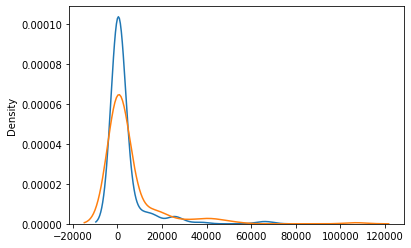

In [38]:
mean_indices_1 = np.array([x.mean() for x in indices_1])
sns.kdeplot(mean_indices_1[info['target'] == 'typical'])
sns.kdeplot(mean_indices_1[info['target'] == 'asd'])

<AxesSubplot:ylabel='Density'>

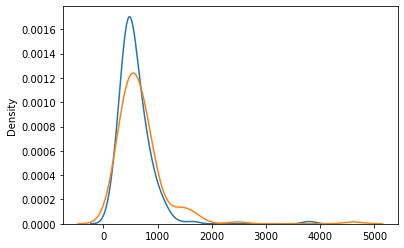

In [40]:
mean_indices_2 = np.array([x.mean() for x in indices_2])
sns.kdeplot(mean_indices_2[info['target'] == 'typical'])
sns.kdeplot(mean_indices_2[info['target'] == 'asd'])

In [70]:
sfreq=125

def plot_eeg_index(eeg, age, index, threshold, title=None):
    n_seconds = eeg.n_times // sfreq
    y_max = np.quantile(abs(eeg[:][0]), 0.995)

    fig, axes = plt.subplots(19, 1, figsize=(3 * n_seconds, 12))
    if title is not None:
        fig.suptitle(title, fontsize=16)

    for ch_name, ax in zip(ch_names, axes):
        index_val = 0.
        signal, times = eeg[ch_name]
        ax.plot(times, signal.flatten(), linewidth=1)
        mask = index(signal, age).ravel() > threshold
        start_ix, end_ix = find_borders(mask)
        for start, end in zip(times[start_ix], times[end_ix]):
            if end - start < .1:
                continue
            ax.axvspan(start, end, color='r', alpha=.15, ymin=.15, ymax=.85)
            index_val += end - start
        ax.set_ylabel(f"{ch_name} ({index_val / n_seconds:.2f})", rotation=0, labelpad=25, fontsize=13)

    axes[0].set_ylabel(ch_names[0], rotation=0, labelpad=-30, fontsize=13)

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(0, n_seconds)
        ax.set_ylim(-y_max, y_max)
        ax.patch.set_alpha(0)
        ax.set_xticks([])
        ax.set_yticks([])

    axes[-1].spines['bottom'].set_visible(True)
    axes[-1].set_xticks(np.arange(n_seconds))
    axes[0].set_yticks([0, y_max])
    axes[0].set_yticklabels([0, f"{y_max * 1e6:.2f} mV"])

    fig.subplots_adjust(hspace=-0.3)

,fn,target,dataset_name,sfreq,age,seconds
67,dekanev_stepan_7_fon_19.raw.fif,asd,asd,125,7,46.0


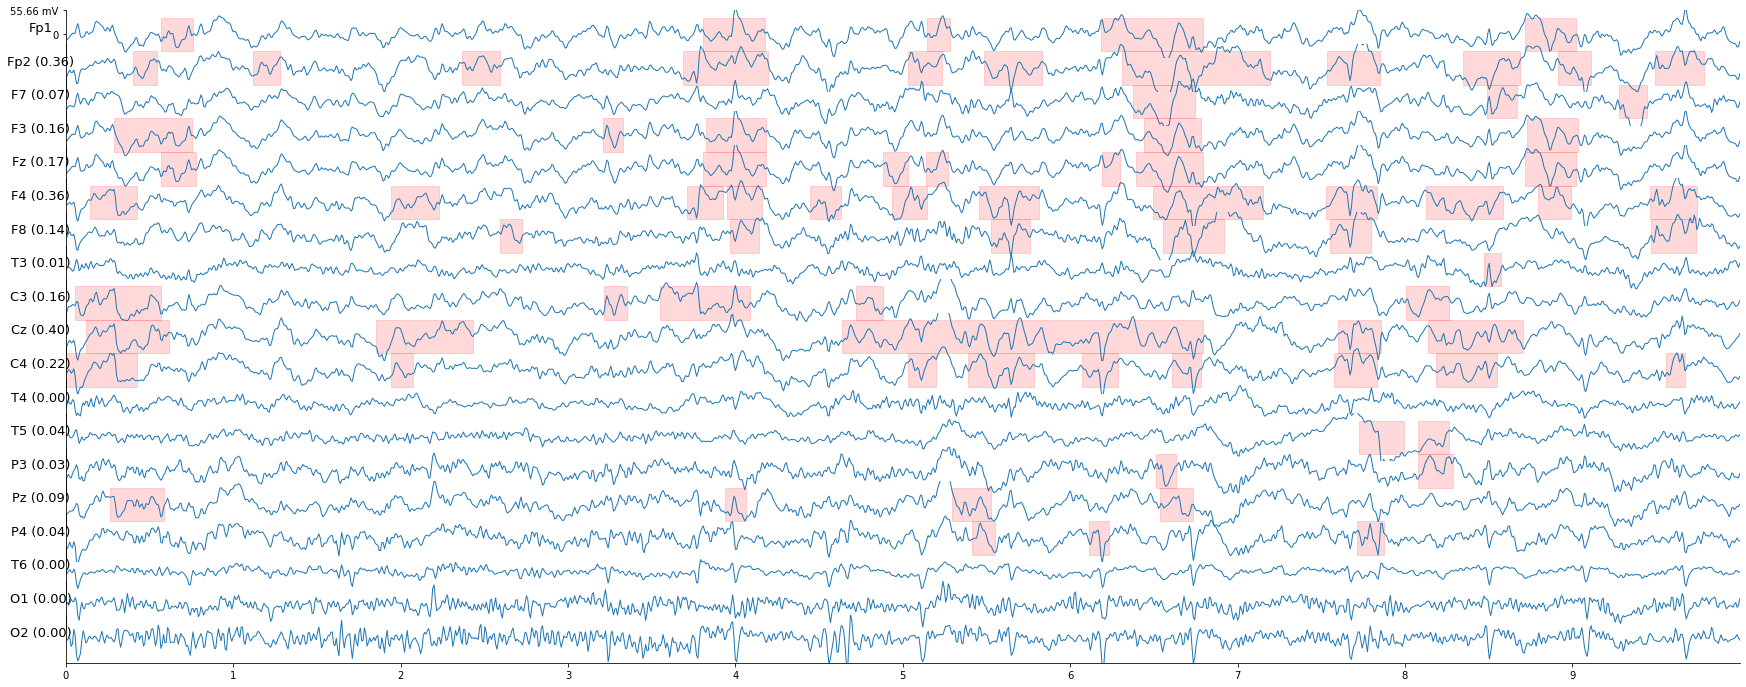

In [71]:
# Subject 70
plot_eeg_index(eegs[67].copy().load_data().crop(19, 29), 7, index_2, 1000)
info[info["fn"] == "dekanev_stepan_7_fon_19.raw.fif"]

,fn,target,dataset_name,sfreq,age,seconds
80,g_anton_7_asd_new_19.raw.fif,asd,asd,125,7,81.0


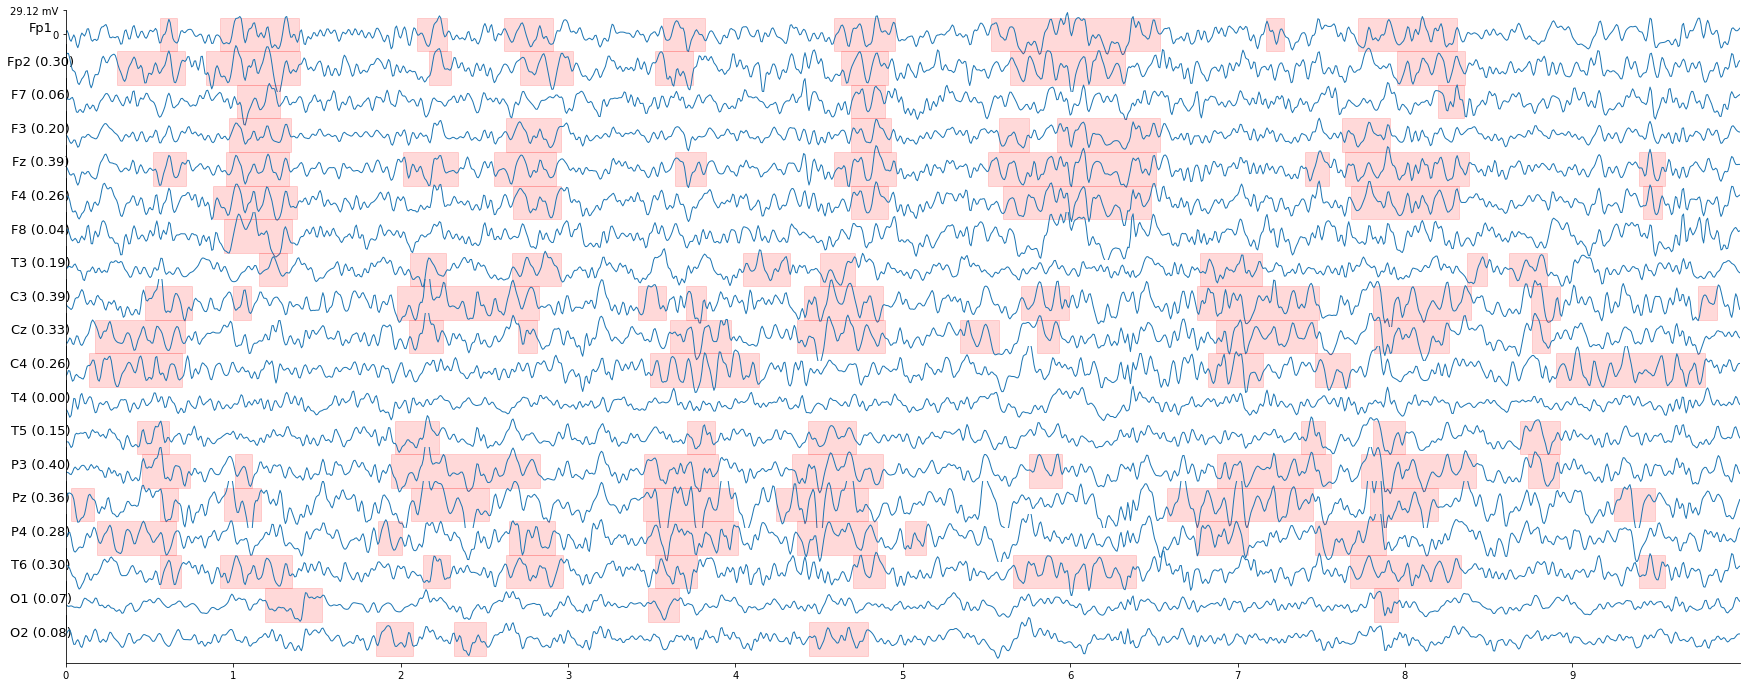

In [72]:
# Subject 80
plot_eeg_index(eegs[80].copy().load_data().crop(68, 78), 7, index_2, 1000)
info[info["fn"] == "g_anton_7_asd_new_19.raw.fif"]

,fn,target,dataset_name,sfreq,age,seconds
206,лева 9 норма_19.raw.fif,typical,typical,125,9,45.0


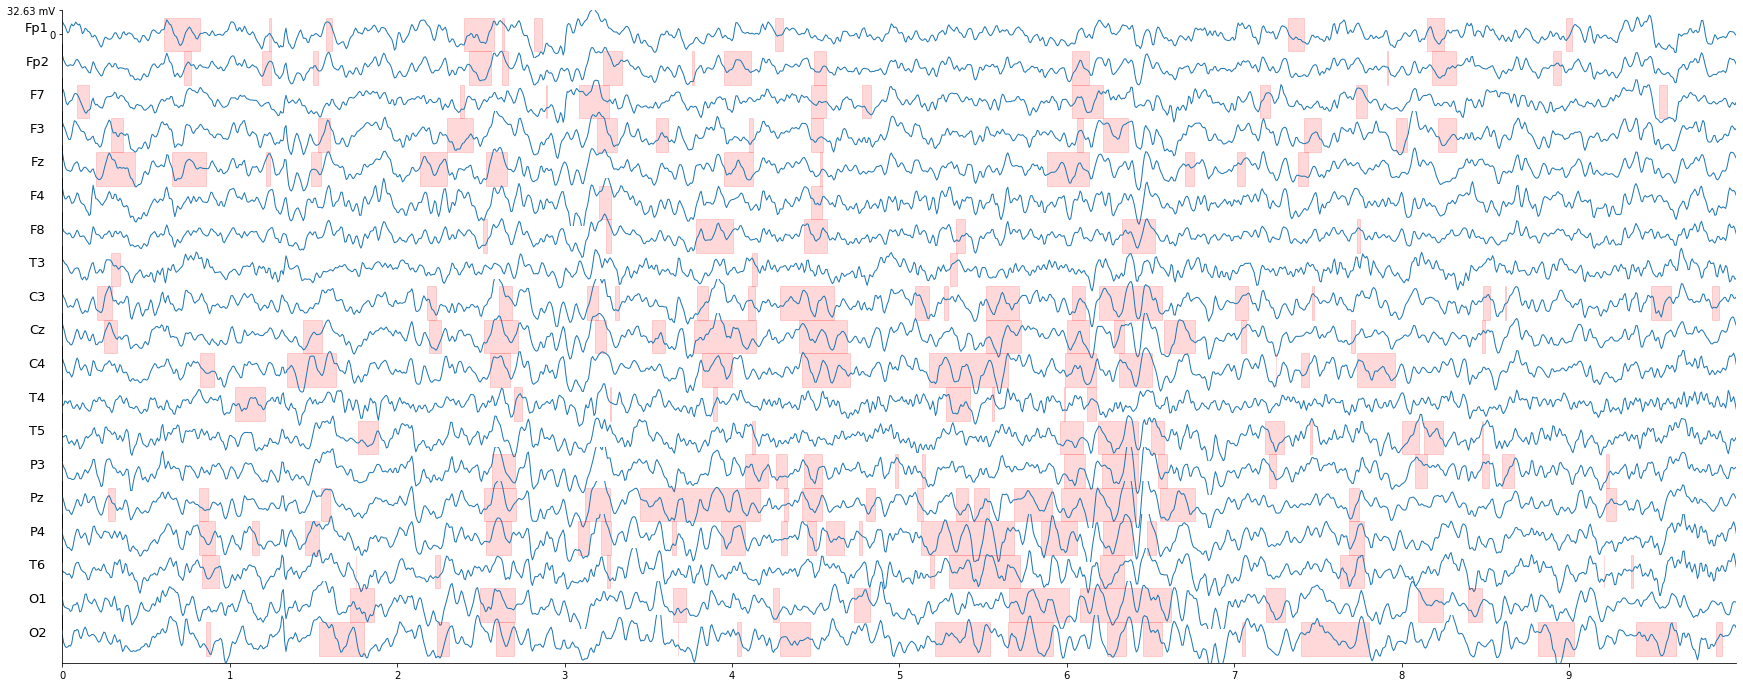

In [35]:
# Sbuject 213
plot_eeg_index(eegs[206].copy().load_data().crop(21, 31), 9, index_1, 15)
info[info["fn"] == "лева 9 норма_19.raw.fif"]

,fn,target,dataset_name,sfreq,age,seconds
139,fill_asd_7_m_19.raw.fif,asd,asd,125,7,120.0


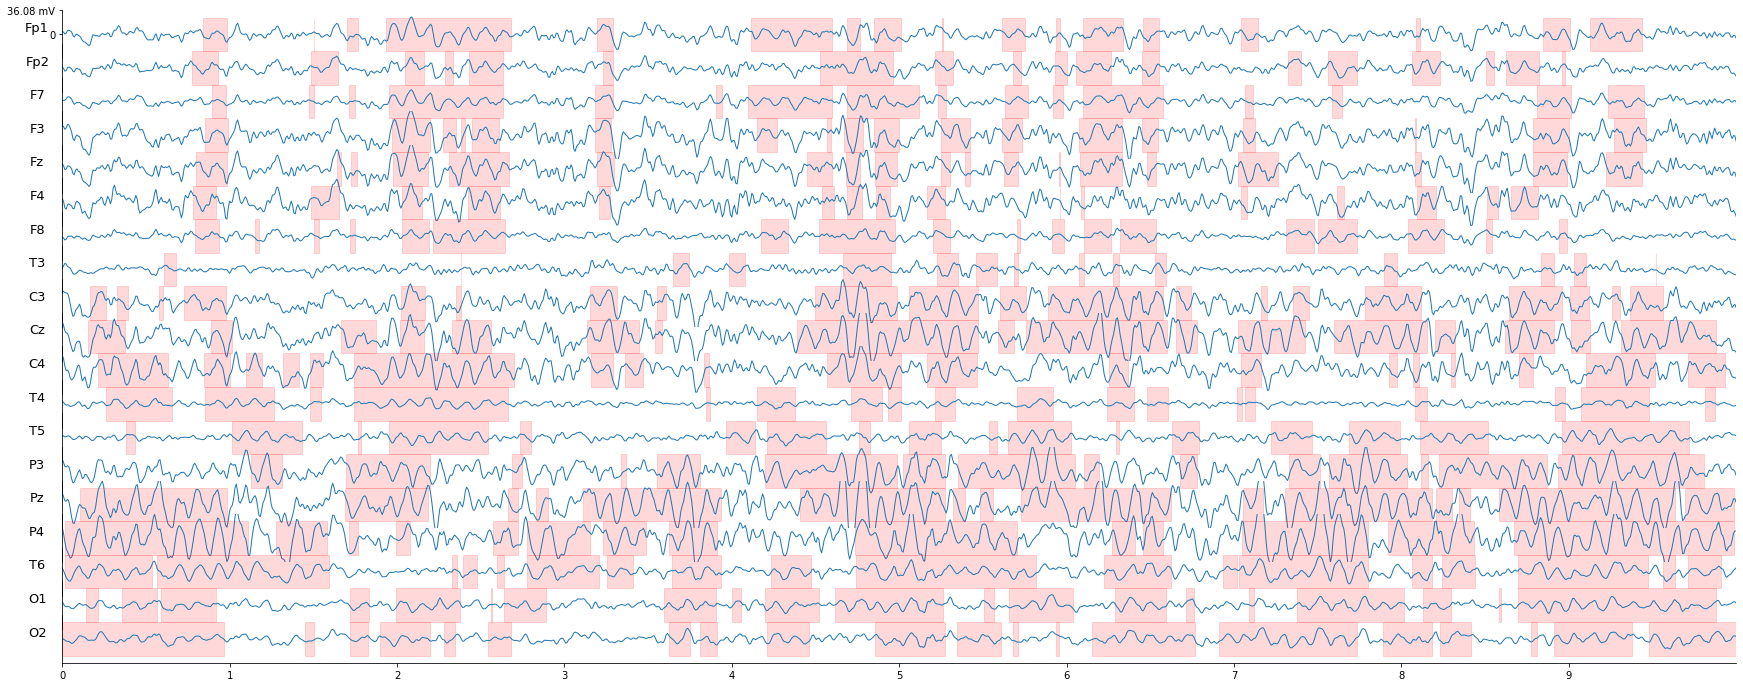

In [37]:
# Sbuject 143
plot_eeg_index(eegs[139].copy().load_data().crop(25, 35), 7, index_1, 15)
info[info["fn"] == "fill_asd_7_m_19.raw.fif"]